In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Activation,Input,BatchNormalization,Flatten, Dense, Conv2D, MaxPool2D,AveragePooling2D,Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


ERROR! Session/line number was not unique in database. History logging moved to new session 101


In [6]:
#bottleneck code
class BottleNeck(tf.keras.layers.Layer):
    def __init__(self,num_filters,stride):
        super(BottleNeck,self).__init__()
        self.conv1=Conv2D(filters=num_filters,kernel_size=(1,1),strides=(1,1),padding= 'same')
        self.bn1=BatchNormalization()
        
        self.conv2=Conv2D(filters=num_filters,kernel_size=(3,3), strides=stride,padding='same')
        self.bn2=BatchNormalization()
        
        self.conv3=Conv2D(filters=num_filters*4,kernel_size=(1,1), strides=(1,1),padding='same')
        self.bn3=BatchNormalization()
        #3개의 layer중 1,2번째는 filter 수가 같고, 마지막은 4배의 filter수 갖고 있음
        #stride 변수는 폭에의한 변화 , conv2_x는 1, 나머지는 stride=2로 설정
        
        self.shortcut=Sequential()
        self.shortcut.add(Conv2D(num_filters*4,kernel_size=(1,1), strides=stride,padding='same'))
        self.shortcut.add(BatchNormalization())
        
        #layer 합쳐주는 call
    def call(self, inputs,training=None,**kwargs):
        #none으로 둬서 batch norm drop out이 활성화하게 함 기본적으로 학습 중이지만 필요에 따라 사용자가 지정할 수 있게
        x=self.conv1(inputs)
        x=tf.nn.relu(self.bn1(x)) #batchnormalization실행 후 relu 로 x 업데이트
        x=self.conv2(x)
        x=tf.nn.relu(self.bn2(x))
        x=self.bn3(self.conv3(x))
        output=tf.nn.relu(tf.keras.layers.add([self.shortcut(inputs),x]))
        #output x와 shortcut의 output 더해주어 최종 output 데이터 값
        return output

def _make_layer(num_filters, num_blocks, stride):
    res_block = tf.keras.Sequential()
    res_block.add(BottleNeck(num_filters, stride))

    for _ in range(1, num_blocks):
        res_block.add(BottleNeck(num_filters,stride=1))
    return res_block
"""_ 는 더미 값,
       for _ in range(5):
        print("Hello")
        이 코드의 경우 변수인 0-4까지의 수는 사용하지 않고 print만 되고 있음
        이럴 때 그냥 더미로 _ 를 이용
        """
  #stride 한 번이면 output size 반쪽, 반복적으로 stride가 1이 아니면 점점 줄어들음. 한번만 stride값 변경
  #나머지는 stride 1로 정의

class ResNet(tf.keras.Model):
    def __init__(self,num_block,num_units=10):
        super(ResNet, self).__init__()
        #num block 바꾸면 어떤 resnet 층이든 만들 수 있다.(50 이상)
        
        self.conv1=Conv2D(filters=64,kernel_size=(7,7),strides=(2,2),padding='same')
        self.bn1=BatchNormalization()
        
        self.mp1=MaxPool2D(pool_size=(3,3),strides=(2,2),padding='same')
        self.bn2=BatchNormalization()
        
        self.bt1=_make_layer(64,num_block[0],1)
        self.bt2=_make_layer(128,num_block[1],2)
        self.bt3=_make_layer(256,num_block[2],2)
        self.bt4=_make_layer(512,num_block[3],2)
        
        self.av1=AveragePooling2D(pool_size=(1,1),strides=(1,1))
        self.flatten=Flatten()
        self.ds1=Dense(units=2048,activation='relu')
        self.ds2=Dense(units=1000,activation='relu')
        self.ds3=Dense(units=num_units,activation='softmax')
        
        #input 넣었을 때 call
    def call(self, inputs,training=None,mask=None):
        x=self.conv1(inputs)
        x=self.bn1(x,training=training)
        x=tf.nn.relu(x)
        x=self.mp1(x)
        x=self.bn2(x)
        x=self.bt1(x,training=training)
        x=self.bt2(x,training=training)
        x=self.bt3(x,training=training)
        x=self.bt4(x,training=training)
        x=self.av1(x)
        x=self.flatten(x)
        x=self.ds1(x)
        x=self.ds2(x)
        output=self.ds3(x)
        return output
"""
배치 정규화는 모델을 훈련할 때 주로 사용되며, 각 미니배치의 평균 및 표준편차를 
사용하여 데이터를 정규화합니다. 이때, 훈련 중인지 여부에 따라 정규화에 사용되는 
평균과 표준편차가 달라집니다. training=True로 설정되면 현재 훈련 중이며, 훈련 중에는 
현재 미니배치의 평균과 표준편차를 사용하여 정규화를 수행합니다. training=False로 
설정되면 테스트 또는 추론 중이며, 이때는 훈련 중 계산된 이동 평균 및 이동 표준편차를 
사용하여 정규화를 수행합니다.

따라서 self.bn1(x, training=training)은 입력 데이터 x에 배치 정규화를 적용하고, 
훈련 중인지 여부에 따라 적절한 통계 값을 사용하여 정규화를 수행합니다.
"""
def ResNet50():
    return ResNet(num_block=[3,4,5,3])

def get_model():
    model=ResNet50()
    model.build(input_shape=(None,32,32,3))
    model.summary()
    return model

model=get_model()
"""
여기서 input_shape은 모델의 입력 데이터의 형태를 지정합니다. (None, 224, 224, 3)은 
각각 배치 크기를 제외한 이미지의 높이, 너비 및 채널 수를 나타냅니다.

모델은 처음 사용될 때 자동으로 build 메서드를 호출하며, 이때 입력 데이터의 형태에 
맞추어 가중치를 생성합니다. 따라서 모델을 처음 사용하기 전에 build 메서드를 
명시적으로 호출하여 가중치를 초기화할 수도 있습니다."""


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Model: "res_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           multiple                  9472      
_________________________________________________________________
batch_normalization_62 (Batc multiple                  256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
batch_normalization_63 (Batc multiple                  256       
_________________________________________________________________
sequential_19 (Sequential)   multiple                  353664    
____________________________________________

'\n여기서 input_shape은 모델의 입력 데이터의 형태를 지정합니다. (None, 224, 224, 3)은 \n각각 배치 크기를 제외한 이미지의 높이, 너비 및 채널 수를 나타냅니다.\n\n모델은 처음 사용될 때 자동으로 build 메서드를 호출하며, 이때 입력 데이터의 형태에 \n맞추어 가중치를 생성합니다. 따라서 모델을 처음 사용하기 전에 build 메서드를 \n명시적으로 호출하여 가중치를 초기화할 수도 있습니다.'

In [8]:
def visualize_data(images, categories, class_names):
    fig = plt.figure(figsize=(14, 6))
    fig.patch.set_facecolor('white')
    for i in range(3 * 7):
        plt.subplot(3, 7, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i])
        class_index = categories[i].argmax()
        plt.xlabel(class_names[class_index])
    plt.show()
def load_cifar10_dataset():
    (train_validation_images, train_validation_labels), (test_images, test_labels) \
    = cifar10.load_data()
    
    train_validation_images = train_validation_images / 255
    test_images = test_images / 255.
    
    width_shift = 3/33
    height_shift = 3/32
    flip = True
    
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    num_classes = len(class_names)

    datagen = ImageDataGenerator(
    horizontal_flip=flip,
    width_shift_range=width_shift,
    height_shift_range=height_shift,
    )
    datagen.fit(train_x)
    it = datagen.flow(train_x, train_x, shuffle=False)
    batch_images, batch_labels = next(it)
    visualize_data(batch_images, batch_labels, class_names)
    
    n_train_validation = train_validation_images.shape[0]
    train_ratio = 0.8
    n_train = int(n_train_validation * train_ratio)
    
    train_x = train_validation_images[:n_train]
    train_y = train_validation_labels[:n_train]
    validation_x = train_validation_images[n_train:]
    validation_y = train_validation_labels[n_train:]
    test_x = test_images
    test_y = test_labels

    print('Train set')
    print('Image :', batch_images.shape)
    print('Label :', batch_labels.shape)
    print('Validation set')
    print('Image :', validation_x.shape)
    print('Label :', validation_y.shape)
    print('Train & validation set')
    print('Image :', test_x.shape)
    print('Label :', test_y.shape)
    
    return batch_images, batch_labels, validation_x, validation_y, test_x, test_y



ERROR! Session/line number was not unique in database. History logging moved to new session 104


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tlsdu\AppData\Local\Temp\ipykernel_19116\1585185143.py", line 1, in <module>
    batch_images, batch_labels, validation_x, validation_y, test_x, test_y = load_cifar10_dataset()
  File "C:\Users\tlsdu\AppData\Local\Temp\ipykernel_19116\4145947123.py", line 45, in load_cifar10_dataset
    visualize_data(batch_images, batch_labels, class_names)
  File "C:\Users\tlsdu\AppData\Local\Temp\ipykernel_19116\4145947123.py", line 10, in visualize_data
    plt.xlabel(class_names[class_index])
IndexError: list index out of range

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._rende

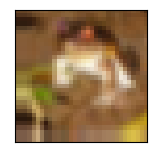

In [ ]:

batch_images, batch_labels, validation_x, validation_y, test_x, test_y = load_cifar10_dataset()


batch_labels= to_categorical(batch_labels,10)

validation_y = to_categorical(validation_y,10)

test_y = to_categorical(test_y,10)




In [17]:
# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss',  # 모니터링할 성능 지표
                               patience=5,          # 성능 향상이 없을 때 몇 번까지 기다릴지 설정
                               restore_best_weights=True) 
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(train_x, train_y, epochs=100, batch_size=64,validation_data=(validation_x, validation_y))


ERROR! Session/line number was not unique in database. History logging moved to new session 85
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 49s 1ms/sample - loss: 0.0541 - accuracy: 0.9844 - val_loss: 1.7252 - val_accuracy: 0.7024
Epoch 2/100
40000/40000 [==============================] - 43s 1ms/sample - loss: 0.0455 - accuracy: 0.9858 - val_loss: 1.4068 - val_accuracy: 0.7519
Epoch 3/100
40000/40000 [==============================] - 43s 1ms/sample - loss: 0.0487 - accuracy: 0.9852 - val_loss: 1.3099 - val_accuracy: 0.7573
Epoch 4/100
40000/40000 [==============================] - 44s 1ms/sample - loss: 0.1473 - accuracy: 0.9525 - val_loss: 1.2332 - val_accuracy: 0.7344
Epoch 5/100
40000/40000 [==============================] - 44s 1ms/sample - loss: 0.0508 - accuracy: 0.9848 - val_loss: 1.3018 - val_accuracy: 0.7584
Epoch 6/100
40000/40000 [==============================] - 44s 1ms/sample - loss: 0.0266 - accuracy: 0.99

In [18]:
test_loss, test_acc = model.evaluate(test_x, test_y)

10000/10000 [==============================] - 4s 423us/sample - loss: 1.5525 - accuracy: 0.7288


C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


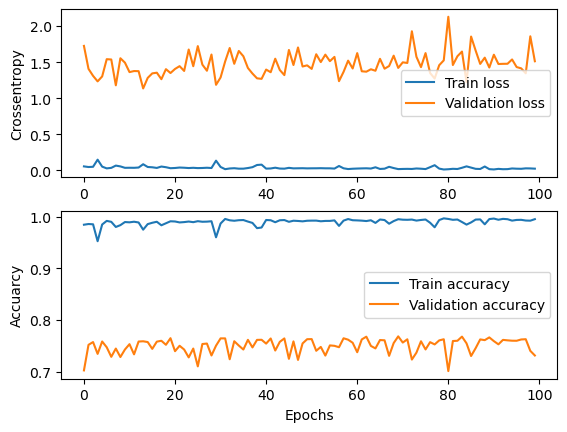

In [19]:
fig, axes = plt.subplots(2,1)

axes[0].plot(history.history['loss'], label='Train loss')
axes[0].plot(history.history['val_loss'], label='Validation loss')
axes[0].set_ylabel('Crossentropy')
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='Train accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation accuracy')
axes[1].set_ylabel('Accuarcy')
axes[1].legend()
axes[1].set_xlabel('Epochs')

fig.show()

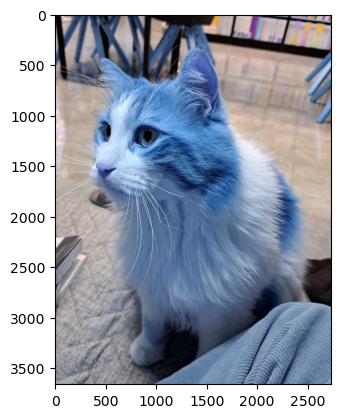

In [20]:
import cv2
img = cv2.imread('cat_image.jpg') #사진 읽어들이기

#이미지 출력

plt.imshow(img)
plt.show()


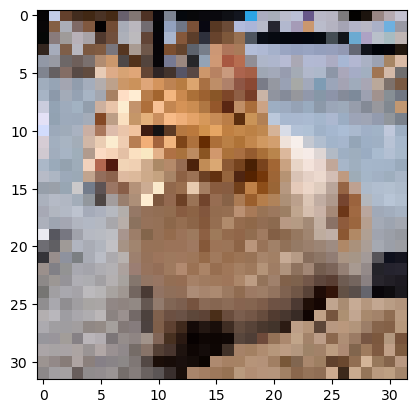

'\nresize는 이미지 크기가 변하는 것이 아닌 픽셀 수가 변경되는 것이다. 픽셀수를 줄이면\n그만큼 파일을 손상한 것이기 때문에 다시 늘린다고 원본의 해상도로 돌릴 수 없다.\n'

In [21]:
img=cv2.resize(img,(32,32))
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

"""
resize는 이미지 크기가 변하는 것이 아닌 픽셀 수가 변경되는 것이다. 픽셀수를 줄이면
그만큼 파일을 손상한 것이기 때문에 다시 늘린다고 원본의 해상도로 돌릴 수 없다.
"""


In [22]:
img = np.expand_dims(img, axis=0)  # 4차원으로 확장
print(img.shape)

(1, 32, 32, 3)


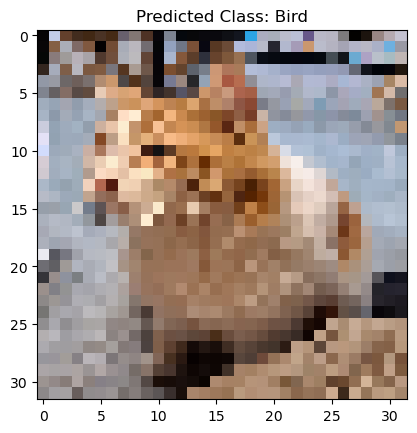

In [23]:
predictions = model.predict(img)

# Define the class labels for CIFAR-10
class_labels = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

# Interpret the results
predicted_class = np.argmax(predictions)
predicted_label = class_labels[predicted_class]

# Display the image and predicted class label
plt.title(f"Predicted Class: {predicted_label}")
plt.imshow(img[0])
plt.show()